# Post Processing

This notebook is used to post process submissions. It's divided into 5 majors steps :
1. Extract automatically all archives from the input directory.
2. Convert all denses point cloud files (`.las` or `.laz`) into DEMs with `point2dem` command from ASP.
3. Coregister DEMs with references DEMs. And compute difference between coregistered DEMs and references DEMs.
4. Compute some global statistics on all the Post Processing.
5. Generate some plots.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import history
import history.postprocessing.visualization as viz
from pathlib import Path
import pandas as pd
import numpy as np

## Settings and Paths Managing

For the post Preprocessing workflow their is a lot of directory and paths. To simplify it, let's used the class `history.postprocessing.PathsManager`. 

In [3]:
BASE_DIR = Path("/mnt/summer/USERS/DEHECQA/history/output") 

CUSTOM_PATHS = {
    "processing_dir": BASE_DIR / "test_data",
    "raw_dems_dir": BASE_DIR / "test_data" / "dems",
    "coreg_dems_dir": BASE_DIR / "test_data" / "coregistered_dems",
    "casagrande_ref_dem_zoom": BASE_DIR / "test_data" / "ref_lowres_dems" / "casa_grande_reference_dem_zoom_30m.tif",
    "casagrande_ref_dem_large": Path("/mnt/summer/USERS/DEHECQA/history/data_final") / "casa_grande" / "aux_data" / "reference_dem_large.tif",
    "iceland_ref_dem_zoom": BASE_DIR / "test_data" / "ref_lowres_dems" / "iceland_reference_dem_zoom_30m.tif",
    "iceland_ref_dem_large": Path("/mnt/summer/USERS/DEHECQA/history/data_final") / "iceland" / "aux_data" / "reference_dem_large.tif",
}
paths_manager = history.postprocessing.PathsManager(BASE_DIR, CUSTOM_PATHS)

# other settings
OVERWRITE = False
DRY_RUN = False # set this to True to avoid process
MAX_WORKERS = 4
VERBOSE = True

postproc = history.postprocessing.PostProcessing(paths_manager)

## Step 1 : extract submissions

In [ ]:
postproc.uncompress_all_submissions(OVERWRITE, DRY_RUN, VERBOSE)

## Visualize Post Processing files

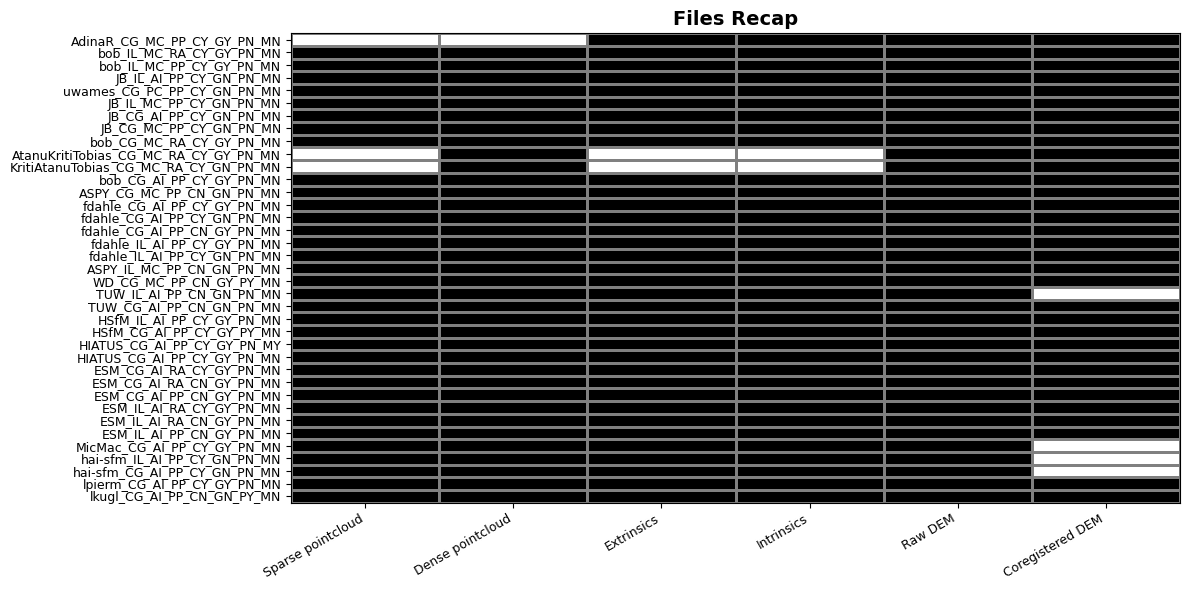

In [4]:
postproc.plot_files_recap()

## Step 2: Convert Dense Point Cloud Files into DEMs

This step processes **dense point cloud files** to generate DEMs that are spatially aligned with their corresponding reference DEMs.

- **Input search**: Point cloud files are searched **recursively** in the directory `extracted_submissions_dir` using the pattern `*_dense_pointcloud.{las,laz}`.  
- **Output location**: The resulting DEMs are saved in the directory `raw_dems_dir`.  
- **Reference selection**: For each point cloud file, the appropriate reference DEM is selected based on its `site` and `dataset` metadata.  

**Note:**  
The method `iter_point2dem` launches the ASP `point2dem` command with the parameters:  
- `max_concurrent_commands`: Maximum number of parallel `point2dem` processes.  
- `max_threads_per_command`: Maximum number of threads allocated to each individual process.  


In [ ]:
asp_path = None
max_concurrent_commands = 1

postproc.iter_point2dem(OVERWRITE, DRY_RUN, asp_path, max_concurrent_commands, max_threads_per_command=MAX_WORKERS)

### Clean up the RAW_DEM_DIRECTORY
Simply move log files into a folder and eventually remove temporary files

In [ ]:
!mkdir -p {RAW_DEM_DIRECTORY}/log
!mv {RAW_DEM_DIRECTORY}/*-log-point2dem-*.txt {RAW_DEM_DIRECTORY}/log 2>/dev/null || true
!rm -f {RAW_DEM_DIRECTORY}/*-tmp-*.tif

## Step 3: Coregister DEMs

Coregister multiple DEMs in a directory to appropriate reference DEMs and return summary statistics.

This function iterates over all DEM files in `input_directory` ending with '-DEM.tif', 
selects the appropriate reference DEM and mask based on the site and dataset information,
and applies coregistration using the `coregister_dem` function. 

Coregistered DEMs are saved to `output_directory`. If `overwrite` is False, existing output files are skipped.
If `dry_run` is True, no coregistration is performed, only file names and planned operations are printed.

In [ ]:
postproc.iter_coregister_dems(OVERWRITE, DRY_RUN, VERBOSE)

## Step 4: Compute statistics

In [ ]:
postproc.compute_global_df()

In [ ]:
postproc.compute_landcover_stats()

## Step 5 : Generate some plots



In [ ]:
df = postproc.get_global_df()
landcover_df = postproc.get_landcover_stats()

plot_dir = BASE_DIR / "test_data" / "plots"

# print some informations about the global df
participant_number = len(df["author"].unique())
submission_number = len(df)

print(f"Number of participants : {participant_number}")
print(f"Number of submissions : {submission_number}")

print("submission by site/dataset :\n")
print(pd.crosstab(df["dataset"], df["site"]))

generate all statistics plots

In [ ]:
stat_dir = plot_dir / "statistics"
viz.generate_nmad_groupby(df, stat_dir / "nmad")
viz.barplot_var(df, stat_dir, "dense_point_count", "Point count")
viz.barplot_var(df, stat_dir, "nmad_before_coreg", "NMAD before coregistration")
viz.plot_coregistration_shifts(df, stat_dir / "coreg_shifts")
viz.generate_landcover_boxplot_by_dataset_site(landcover_df, stat_dir / "landcover_stats")
viz.generate_landcover_nmad_by_dataset_site(landcover_df, stat_dir / "landcover_stats")

generate individual coregistration plots

In [ ]:
viz.generate_coregistration_individual_plots(df, plot_dir / "coregistration_individual_plots")

generate std dems 

In [ ]:
viz.generate_std_dems_by_dataset_site(df, plot_dir / "std_dems")

generate all mosaic plots (can take a while)

In [ ]:
max_cols = {
    ("aerial", "casa_grande"): 5,
    ("aerial", "iceland"): 4,
    ("kh9mc", "casa_gande"): 4,
    ("kh9mc", "iceland"): 4,
    ("kh9pc", "casa_grande"): 4,
    ("kh9pc", "iceland"): 4,
}

viz.generate_dems_mosaic(df, plot_dir / "mosaic-DEMs", max_cols)
viz.generate_ddems_mosaic(df, plot_dir / "mosaic-DDEMs", max_cols)
viz.generate_hillshades_mosaic(df, plot_dir / "mosaic-hillshades", max_cols)
viz.generate_slopes_mosaic(df, plot_dir / "mosaic-slopes", max_cols)

In [ ]:
outliers_code = [
    "fdahle_CG_AI_PP_CN_GY_PN_MN",
    "fdahle_CG_AI_PP_CY_GN_PN_MN",
    "fdahle_IL_AI_PP_CY_GN_PN_MN",
]

df_without_outliers = df.drop(index=outliers_code)

## Plotting some general statistics without outliers

To remove outliers we will look at the nmad_after_coreg and remove all lines which are to high.

In [ ]:
k = 4

df = postproc.get_global_df().dropna(subset="nmad_before_coreg").copy()
landcover_df = postproc.get_landcover_stats()

# --- compute median and MAD per group (aligned to original index) ---
median = df.groupby(["dataset", "site"])["nmad_after_coreg"].transform("median")
mad = df.groupby(["dataset", "site"])["nmad_after_coreg"].transform(lambda x: np.median(np.abs(x - np.median(x))))

# normalize MAD to be comparable to std (for normal dist: sigma ≈ MAD * 1.4826)
normalized_mad = mad * 1.4826

# filter outliers above the threshold
mask =  df["nmad_after_coreg"] <= median + k * normalized_mad

outlier_codes = df.index[~mask].to_list()
print("outliers : ", outlier_codes)

df_inliers = df.loc[mask]
landcover_df_inliers = landcover_df.loc[~landcover_df["code"].isin(outlier_codes)]

plot_dir_inliers = BASE_DIR / "test_data" / "plots_inliers"

# print some informations about the global df
participant_number = len(df_inliers["author"].unique())
submission_number = len(df_inliers)

print(f"Number of participants : {participant_number}")
print(f"Number of submissions : {submission_number}")

print("submission by site/dataset :\n")
print(pd.crosstab(df_inliers["dataset"], df_inliers["site"]))

generate all statistics plots

In [ ]:
stat_dir_inliers = plot_dir_inliers / "statistics"
viz.generate_nmad_groupby(df_inliers, stat_dir_inliers / "nmad")
viz.barplot_var(df_inliers, stat_dir_inliers, "dense_point_count", "Point count")
viz.barplot_var(df_inliers, stat_dir_inliers, "nmad_before_coreg", "NMAD before coregistration")
viz.plot_coregistration_shifts(df_inliers, stat_dir_inliers / "coreg_shifts")
viz.generate_landcover_boxplot_by_dataset_site(landcover_df_inliers, stat_dir_inliers / "landcover_stats")
viz.generate_landcover_nmad_by_dataset_site(landcover_df_inliers, stat_dir_inliers / "landcover_stats")

generate individual coregistration plots

In [ ]:
viz.generate_coregistration_individual_plots(df_inliers, plot_dir_inliers / "coregistration_individual_plots")

generate std dems 

In [ ]:
viz.generate_std_dems_by_dataset_site(df_inliers, plot_dir_inliers / "std_dems")

In [ ]:
max_cols = {
    ("aerial", "casa_grande"): 5,
    ("aerial", "iceland"): 4,
    ("kh9mc", "casa_gande"): 4,
    ("kh9mc", "iceland"): 4,
    ("kh9pc", "casa_grande"): 4,
    ("kh9pc", "iceland"): 4,
}

viz.generate_dems_mosaic(df_inliers, plot_dir_inliers / "mosaic-DEMs", max_cols)
viz.generate_ddems_mosaic(df_inliers, plot_dir_inliers / "mosaic-DDEMs", max_cols)
viz.generate_hillshades_mosaic(df_inliers, plot_dir_inliers / "mosaic-hillshades", max_cols)
viz.generate_slopes_mosaic(df_inliers, plot_dir_inliers / "mosaic-slopes", max_cols)